In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import scipy.integrate
from torch.func import vmap, jacrev
from torch.utils.data import Dataset, DataLoader

In [2]:
torch.manual_seed(7)
np.random.seed(7)

In [3]:
plt.rcParams["figure.dpi"] = 300  
plt.rcParams["text.usetex"] = True  
plt.rcParams["font.family"] = "serif"  
plt.rcParams["font.size"] = 10

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [136]:
def system(t,z):
  q1 = z[0:1]
  q2 = z[1:2]
  p1 = z[2:3]
  p2 = z[3:4]

  dqdt = np.concatenate([5*p1-p2, -p1+5*p2])
  dpdt = np.concatenate([-q1**3-q1, -q2**3-q2])
  return np.concatenate([dqdt,dpdt])

In [178]:
#Make the dataset
N = 2024 #how many trajectory segments
d = 2 #dimension of configuration space
M = 5 #number of sampled points for each trajectory
T = .03 #final sampling time
time = np.linspace(0,T,M+1)
dt = time[1] - time[0]
print("Delta t = ",dt)
z = 2*np.random.rand(N,2*d)-1 #we suppose them organized as z = [q1,...,qd,p1,...,pd]
q = z[:,:d]
p = z[:,d:]

z = np.concatenate([q,p],axis=1)

Delta t =  0.006


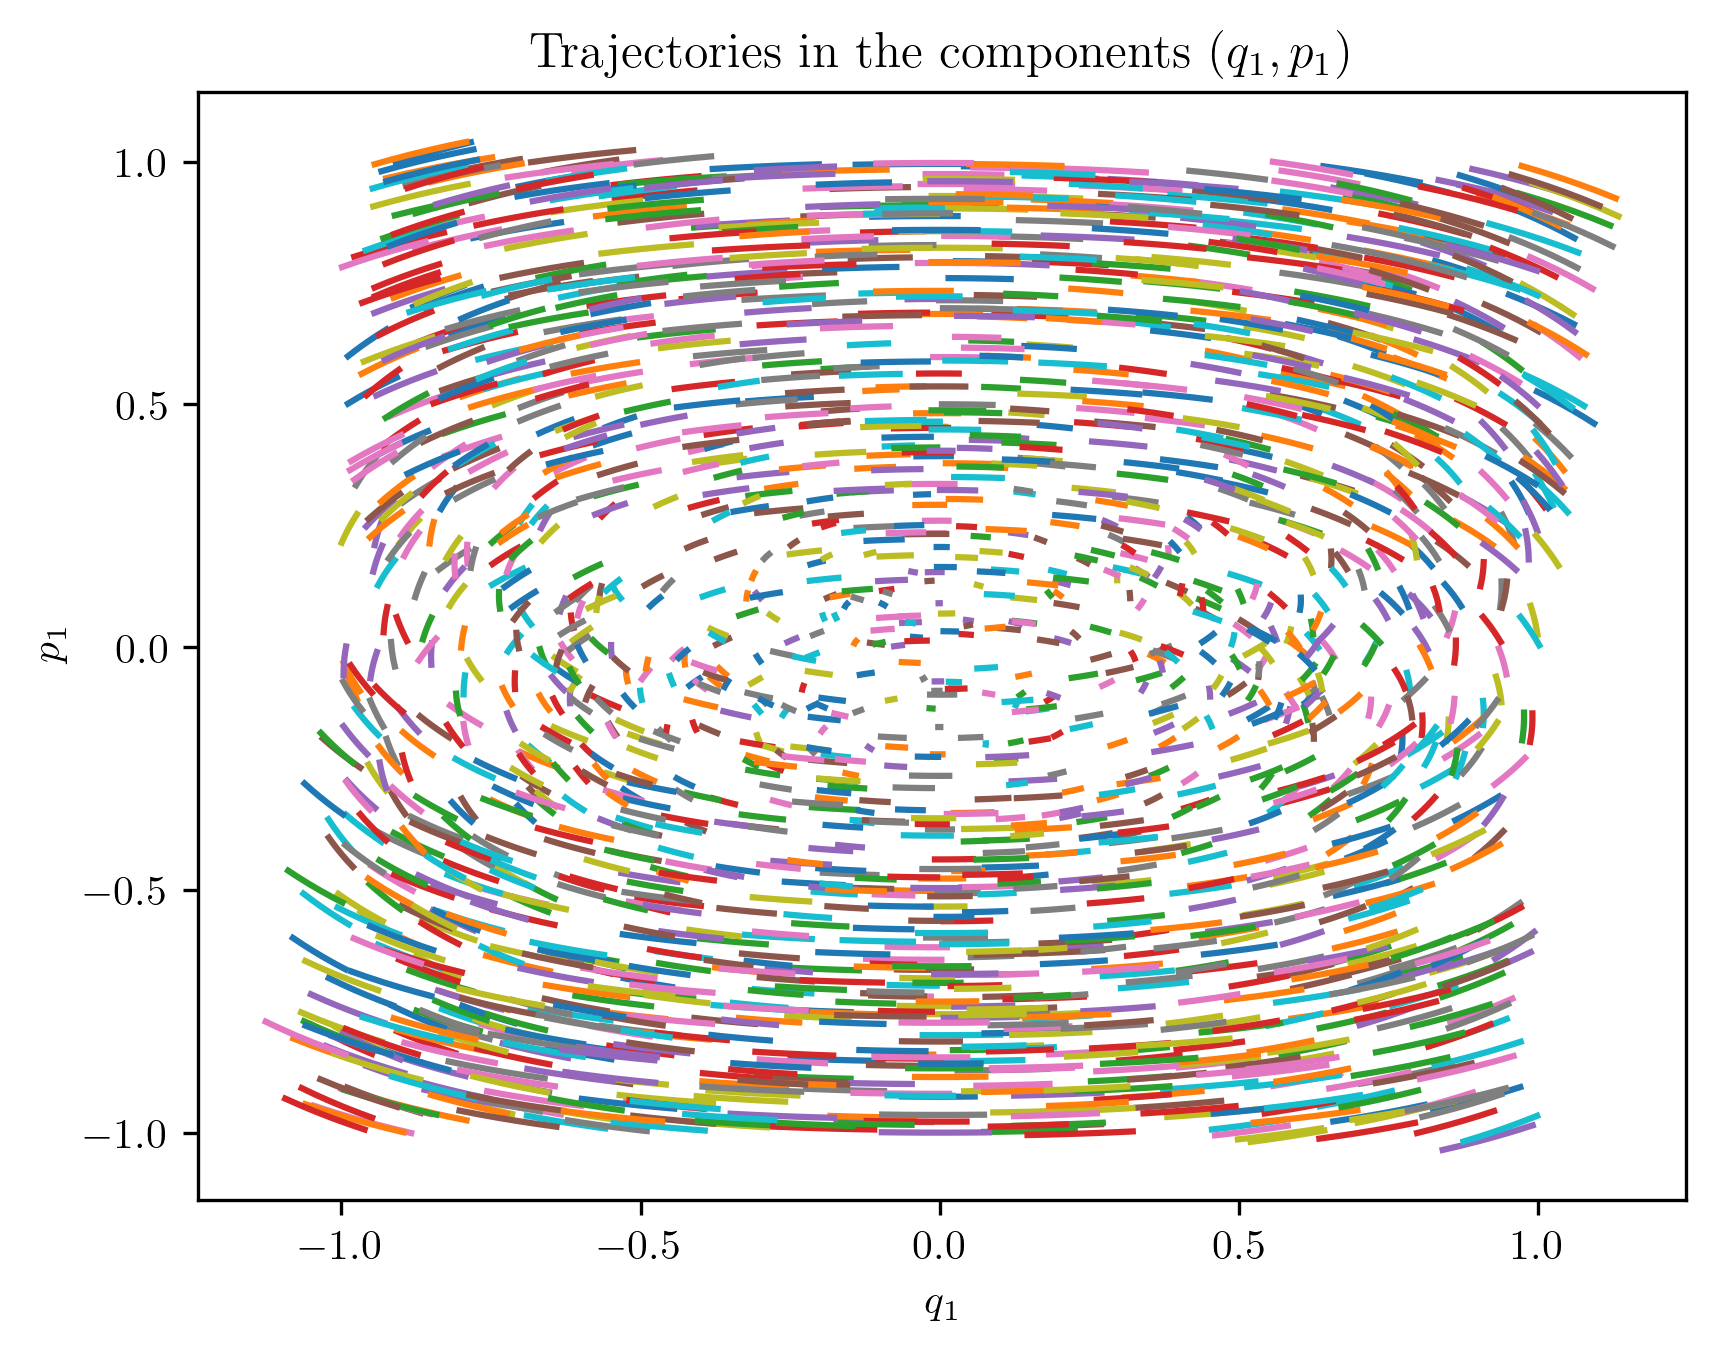

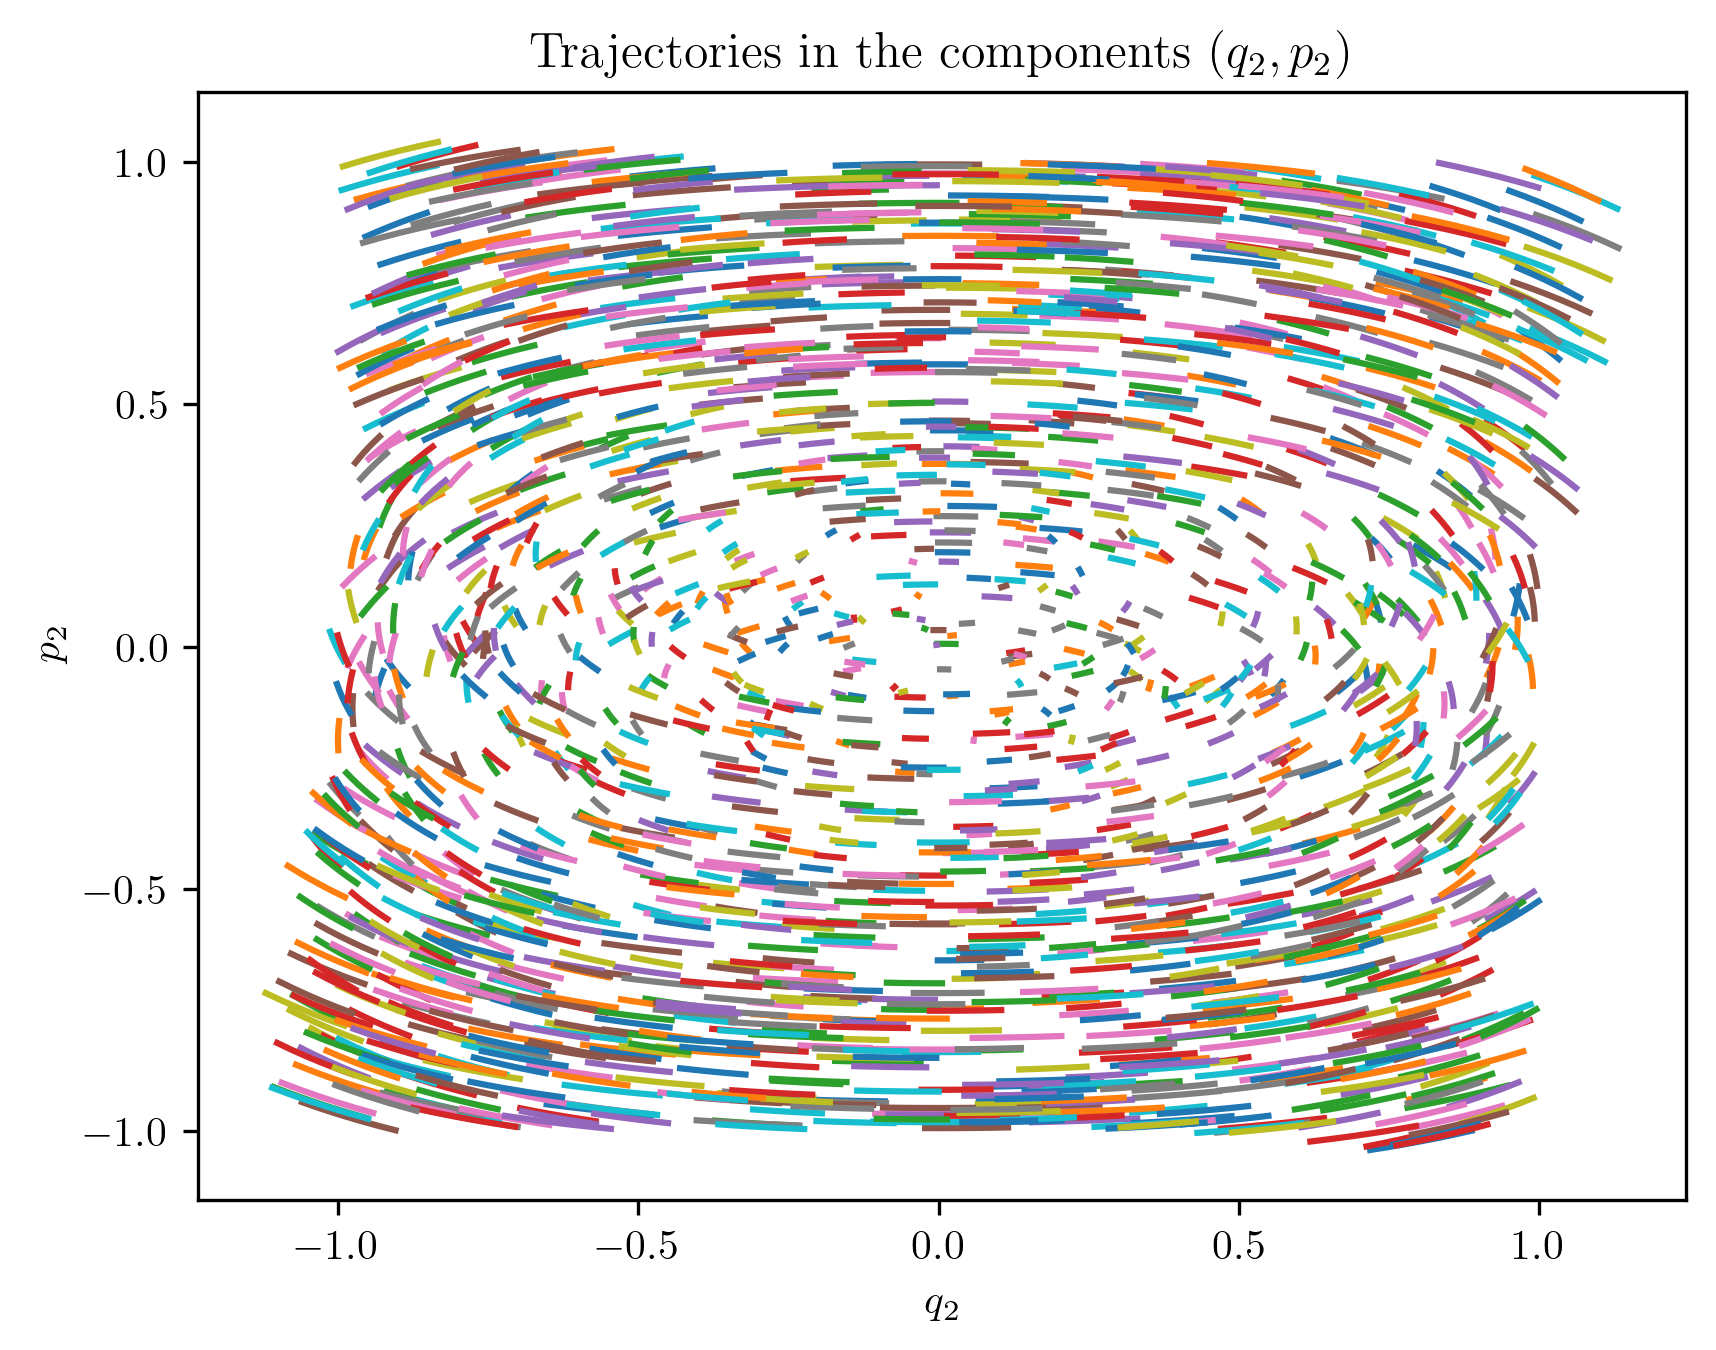

In [180]:
traj = np.zeros([N,2*d,M+1])
for i in range(N):
  traj[i,:,:] = scipy.integrate.solve_ivp(system,[0, T],z[i],method='RK45',t_eval=time,rtol=1e-11,atol=1e-13).y

for i in range(N):
  plt.plot(traj[i,0],traj[i,2])
  plt.xlabel(r"$q_1$")
  plt.ylabel(r"$p_1$")
plt.title(r"Trajectories in the components $(q_1,p_1)$")
plt.show()
for i in range(N):
  plt.plot(traj[i,1],traj[i,3])
  plt.xlabel(r"$q_2$")
  plt.ylabel(r"$p_2$")
plt.title(r"Trajectories in the components $(q_2,p_2)$")
plt.show()

In [181]:
X = traj[:,:,0]
Y = traj[:,:,1:M+1]
Ntrain = N

In [182]:
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.from_numpy(x.astype(np.float32)).to(device)
    self.y = torch.from_numpy(y.astype(np.float32)).to(device)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length

trainset = dataset(X[:Ntrain,:],Y[:Ntrain])

In [183]:
batch_size = 50
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

In [184]:
class SinActivation(nn.Module):
    def __init__(self, ):
        super(SinActivation, self).__init__()
    def forward(self,x):
        return torch.sin(x)

class Hamiltonian(nn.Module):
    def __init__(self, K = 100):
        super(Hamiltonian, self).__init__()
        
        self.nl = nn.Tanh()
        
        self.seq = nn.Sequential(
            nn.Linear(d,K//2),
            self.nl,
            nn.Linear(K//2,K),
            self.nl,
            nn.Linear(K,K),
            self.nl,
            nn.Linear(K,K//2),
            self.nl,
            nn.Linear(K//2,1,bias=False)
        )
       

        self.A = torch.nn.Parameter(torch.randn(d,d))
        self.c = torch.nn.Parameter(torch.randn(1))
        self.M =  self.A #+ self.c**2 #* torch.eye(d)

    def Potential(self, X):
        if len(X.shape)==1:
            X = X.unsqueeze(0)
        return self.seq(X[:,:d])

    def Kinetic(self, X):
        if len(X.shape)==1:
            X = X.unsqueeze(0)
        return (0.5 * torch.linalg.norm(X[:,d:]@self.M,axis=1,ord=2)**2).unsqueeze(1)

    def forward(self, X):
        if len(X.shape)==1:
            X = X.unsqueeze(0)
        return self.Potential(X) + self.Kinetic(X)

### Training with regularization

In [185]:
Ham = Hamiltonian(K=10)
Ham.to(device)

Hamiltonian(
  (nl): Tanh()
  (seq): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Tanh()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=5, bias=True)
    (7): Tanh()
    (8): Linear(in_features=5, out_features=1, bias=False)
  )
)

In [186]:
criterion = nn.MSELoss()

epochs = 500
steps = epochs * len(trainloader)
max_lr = 1e-2
min_lr = 1e-4
optimizer = torch.optim.Adam(Ham.parameters(),lr=min_lr)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
                        optimizer,
                        max_lr=max_lr,
                        div_factor= max_lr / min_lr,
                        total_steps=steps,
                        pct_start=0.4,
                        anneal_strategy="cos",
                    )

In [187]:
I = torch.eye(d)
Z = torch.zeros([d,d])
J1 = torch.cat([Z,I],axis=1)
J2 = torch.cat([-I,Z],axis=1)
J = torch.cat([J1,J2],axis = 0).to(device) #Symplectic matrix
print(J)

tensor([[ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.],
        [-1., -0.,  0.,  0.],
        [-0., -1.,  0.,  0.]])


In [188]:
x = torch.randn(10,2*d)
func = lambda x : Ham(x).reshape(-1)
jacobian_fn = vmap(jacrev(func))(x).squeeze()

In [189]:
jacobian_fn.shape

torch.Size([10, 4])

In [190]:
flatHam = lambda x : Ham(x).reshape(-1)

def ExpEuler(x0):
  N = len(x0) #number of points propagated in time
  x = x0.clone().to(device)
  x.requires_grad_()
  sol = torch.zeros([len(x0), 2*d, M-1]).to(device)
  for i in range(M-1):

    #H = torch.sum(Ham(x))
    #dH = torch.autograd.grad(H, x, create_graph=True)[0]
    dH = vmap(jacrev(flatHam))(x).squeeze()
    XH= -dH@J #compute the Hamiltonian vector field

    x = x + dt * XH 
    sol[:,:,i] = x.to(device)
  
  return(sol) #stored trajectories

def StormerVerlet(x0):
  N = len(x0) #number of points propagated in time
  x = x0.clone().to(device)
  x.requires_grad_()
  sol = torch.zeros([len(x0), 2*d, M])
  for i in range(M):

    #x@Mat1 = [0,x[:,1]], x@Mat0 = [x[:,0],0]
    #q@N0 = [q,0] e p@N1 = [0,p]
    id = torch.eye(d)
    zz = torch.zeros((d,d))
    
    N0 = torch.cat((id,zz),axis=1).to(device)
    N1 = torch.cat((zz,id),axis=1).to(device)

    #H = torch.sum(Ham(x))
    #dH = torch.autograd.grad(H, x, create_graph=True)[0]
    dH = vmap(jacrev(flatHam))(x).squeeze()
    XH= -dH@J
    x = x + dt/2 * (XH[:,d:2*d])@N1 #update p to phalf


    #H1 = torch.sum(Ham(x))
    #dH1 = torch.autograd.grad(H1, x, create_graph=True)[0]
    dH1 = vmap(jacrev(flatHam))(x).squeeze()
    XH1= -dH1@J
    x = x + dt * (XH1[:,0:d])@N0 #update for q 


    #H2 = torch.sum(Ham(x))
    #dH2 = torch.autograd.grad(H2, x, create_graph=True)[0]
    dH2 = vmap(jacrev(flatHam))(x).squeeze()
    XH2= -dH2@J

    x = x + dt/2 * (XH2[:,d:2*d])@N1 #update phalf to pnew
    sol[:,:,i] = x
  return(sol) #stored trajectories

In [191]:
integrator = StormerVerlet

In [192]:
checkpoint = 20

for epoch in range(epochs):

    running_loss = 0.0

    for i, data in enumerate(trainloader):

        optimizer.zero_grad()

        inputs, labels = data[0].to(device), data[1].to(device)
        
        predicted = integrator(inputs)
        loss = criterion(predicted, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        
        if i % checkpoint == 0:  
            print('[%d, %5d] loss: %.10f' %
                  (epoch + 1, i + 1, running_loss / checkpoint))
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.0000548112
[1,    21] loss: 0.0013338039
[1,    41] loss: 0.0013638650
[2,     1] loss: 0.0000690818
[2,    21] loss: 0.0013532565
[2,    41] loss: 0.0013266024
[3,     1] loss: 0.0000717138
[3,    21] loss: 0.0012930311
[3,    41] loss: 0.0013646665
[4,     1] loss: 0.0000592763
[4,    21] loss: 0.0013594765
[4,    41] loss: 0.0013269441
[5,     1] loss: 0.0000801111
[5,    21] loss: 0.0013211510
[5,    41] loss: 0.0013414099
[6,     1] loss: 0.0000491764
[6,    21] loss: 0.0012974073
[6,    41] loss: 0.0013701353
[7,     1] loss: 0.0000692596
[7,    21] loss: 0.0013231641
[7,    41] loss: 0.0013457382
[8,     1] loss: 0.0000546704
[8,    21] loss: 0.0013487374
[8,    41] loss: 0.0013041940
[9,     1] loss: 0.0000598363
[9,    21] loss: 0.0012887146
[9,    41] loss: 0.0013425755
[10,     1] loss: 0.0000577939
[10,    21] loss: 0.0013212908
[10,    41] loss: 0.0013073366
[11,     1] loss: 0.0000786139
[11,    21] loss: 0.0013200225
[11,    41] loss: 0.0012957667
[12,

In [193]:
Ham.eval();

In [194]:
print(f"A: ",Ham.M@Ham.M.T)

A:  tensor([[ 4.9997, -0.9999],
        [-0.9999,  4.9997]], grad_fn=<MmBackward0>)


In [195]:
#if i = 1 it returns q1,p1, if i=2 it returns q2,p2 eventually for all the times available
def get_i(z,i):
  if len(z.shape)==2:
    qi = z[:,0+i-1:1+i-1].reshape(-1,1,1)
    pi = z[:,2+i-1:3+i-1].reshape(-1,1,1)
    return np.concatenate([qi,pi],axis=1)
  if len(z.shape)==3:
    qi = z[:,0+i-1:1+i-1,:]
    pi = z[:,2+i-1:3+i-1,:]
    return np.concatenate([qi,pi],axis=1)

In [196]:
TT = 1
timeEval = np.linspace(0,20*dt,21)

In [197]:
def predictedModel(t,x):
  z = torch.from_numpy(x.astype(np.float32)).to(device).requires_grad_()
  uu = Ham(z.unsqueeze(0))
  dHy = torch.autograd.grad(uu,z)[0].t()
  XHH = (J@dHy).t().cpu().detach().numpy()
  return XHH

In [198]:
Ntest = 100
q = 2*np.random.rand(Ntest,d) - 1
p = 2*np.random.rand(Ntest,d) - 1
ics = np.concatenate([q,p],axis=1) #initial conditions

In [199]:
Ztrue = np.zeros([len(ics),2*d,len(timeEval)])
Zpred = np.zeros([len(ics),2*d,len(timeEval)])

for i in range(Ntest):
  Ztrue[i,:,:] = scipy.integrate.solve_ivp(system,[0, timeEval[-1]],ics[i],method='RK45',t_eval=timeEval,rtol=1e-5,atol=1e-9).y
for i in range(Ntest):
  Zpred[i,:,:] = scipy.integrate.solve_ivp(predictedModel,[0, timeEval[-1]],ics[i],method='RK45',t_eval=timeEval,rtol=1e-5,atol=1e-9).y

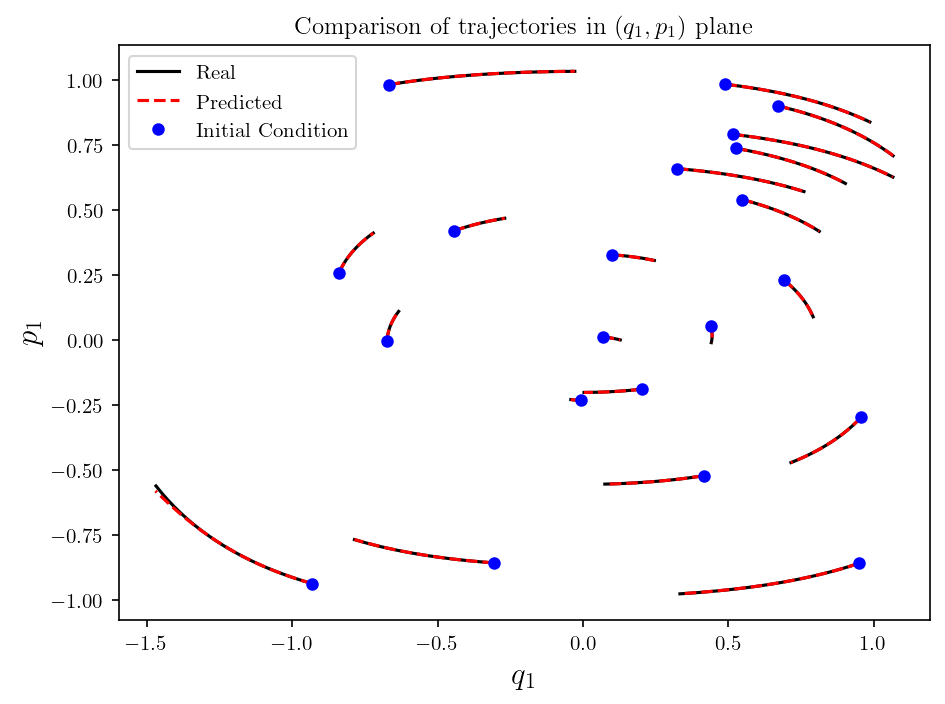

In [200]:
fig, ax = plt.subplots(dpi=150)

ax.plot(Ztrue[0,0],Ztrue[0,2],'k-',markersize=3,label="Real")
ax.plot(Zpred[0,0],Zpred[0,2],'r--',markersize=0.5,label="Predicted")

for i in np.arange(1,Ntest,5):
  #ax.plot(Ztrue[i,0,0],Ztrue[i,2,0],'r*',markersize=3)
  ax.plot(Ztrue[i,0],Ztrue[i,2],'k-',markersize=3)
  ax.plot(Zpred[i,0],Zpred[i,2],'r--',markersize=0.5)
  ax.plot(Zpred[i,0,0],Zpred[i,2,0],'bo',markersize=5)
  
ax.plot(Zpred[0,0,0],Zpred[0,2,0],'bo',markersize=5,label="Initial Condition")

ax.set_xlabel(r"$q_1$",fontsize=15)
ax.set_ylabel(r"$p_1$",fontsize=15)
plt.title(r"Comparison of trajectories in $(q_1,p_1)$ plane")
plt.legend()
plt.tight_layout()
plt.savefig("q1p1.png",dpi=600)
plt.show()

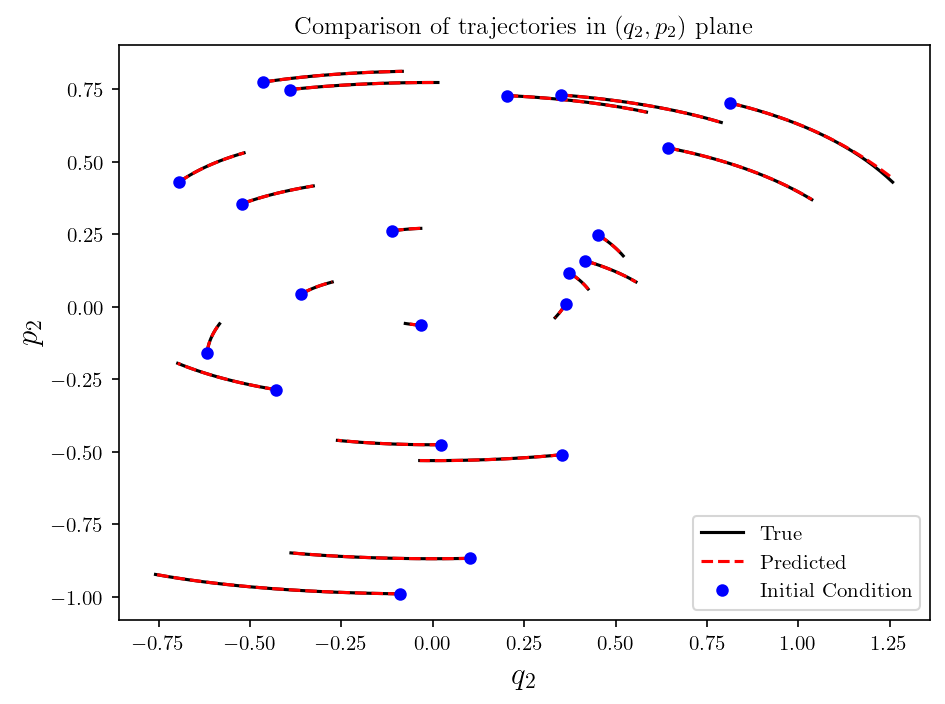

In [201]:
fig, ax = plt.subplots(dpi=150)

ax.plot(Ztrue[0,1],Ztrue[0,3],'k-',markersize=3,label="True")
ax.plot(Zpred[0,1],Zpred[0,3],'r--',markersize=0.5,label="Predicted")

for i in np.arange(1,Ntest,5):
  ax.plot(Ztrue[i,1],Ztrue[i,3],'k-',markersize=3)
  ax.plot(Zpred[i,1],Zpred[i,3],'r--',markersize=0.5)
  ax.plot(Zpred[i,1,0],Zpred[i,3,0],'bo',markersize=5)
ax.plot(Zpred[0,1,0],Zpred[0,3,0],'bo',markersize=5,label="Initial Condition")
 
ax.set_xlabel(r"$q_2$",fontsize=15)
ax.set_ylabel(r"$p_2$",fontsize=15)
plt.title(r"Comparison of trajectories in $(q_2,p_2)$ plane")
plt.legend()
plt.tight_layout()
plt.savefig("q2p2.png",dpi=600)
plt.show()

In [202]:
print("MSE on test trajectories with RK45 as integrator: ",np.mean((Zpred-Ztrue)**2))

MSE on test trajectories with RK45 as integrator:  3.022593592321739e-07


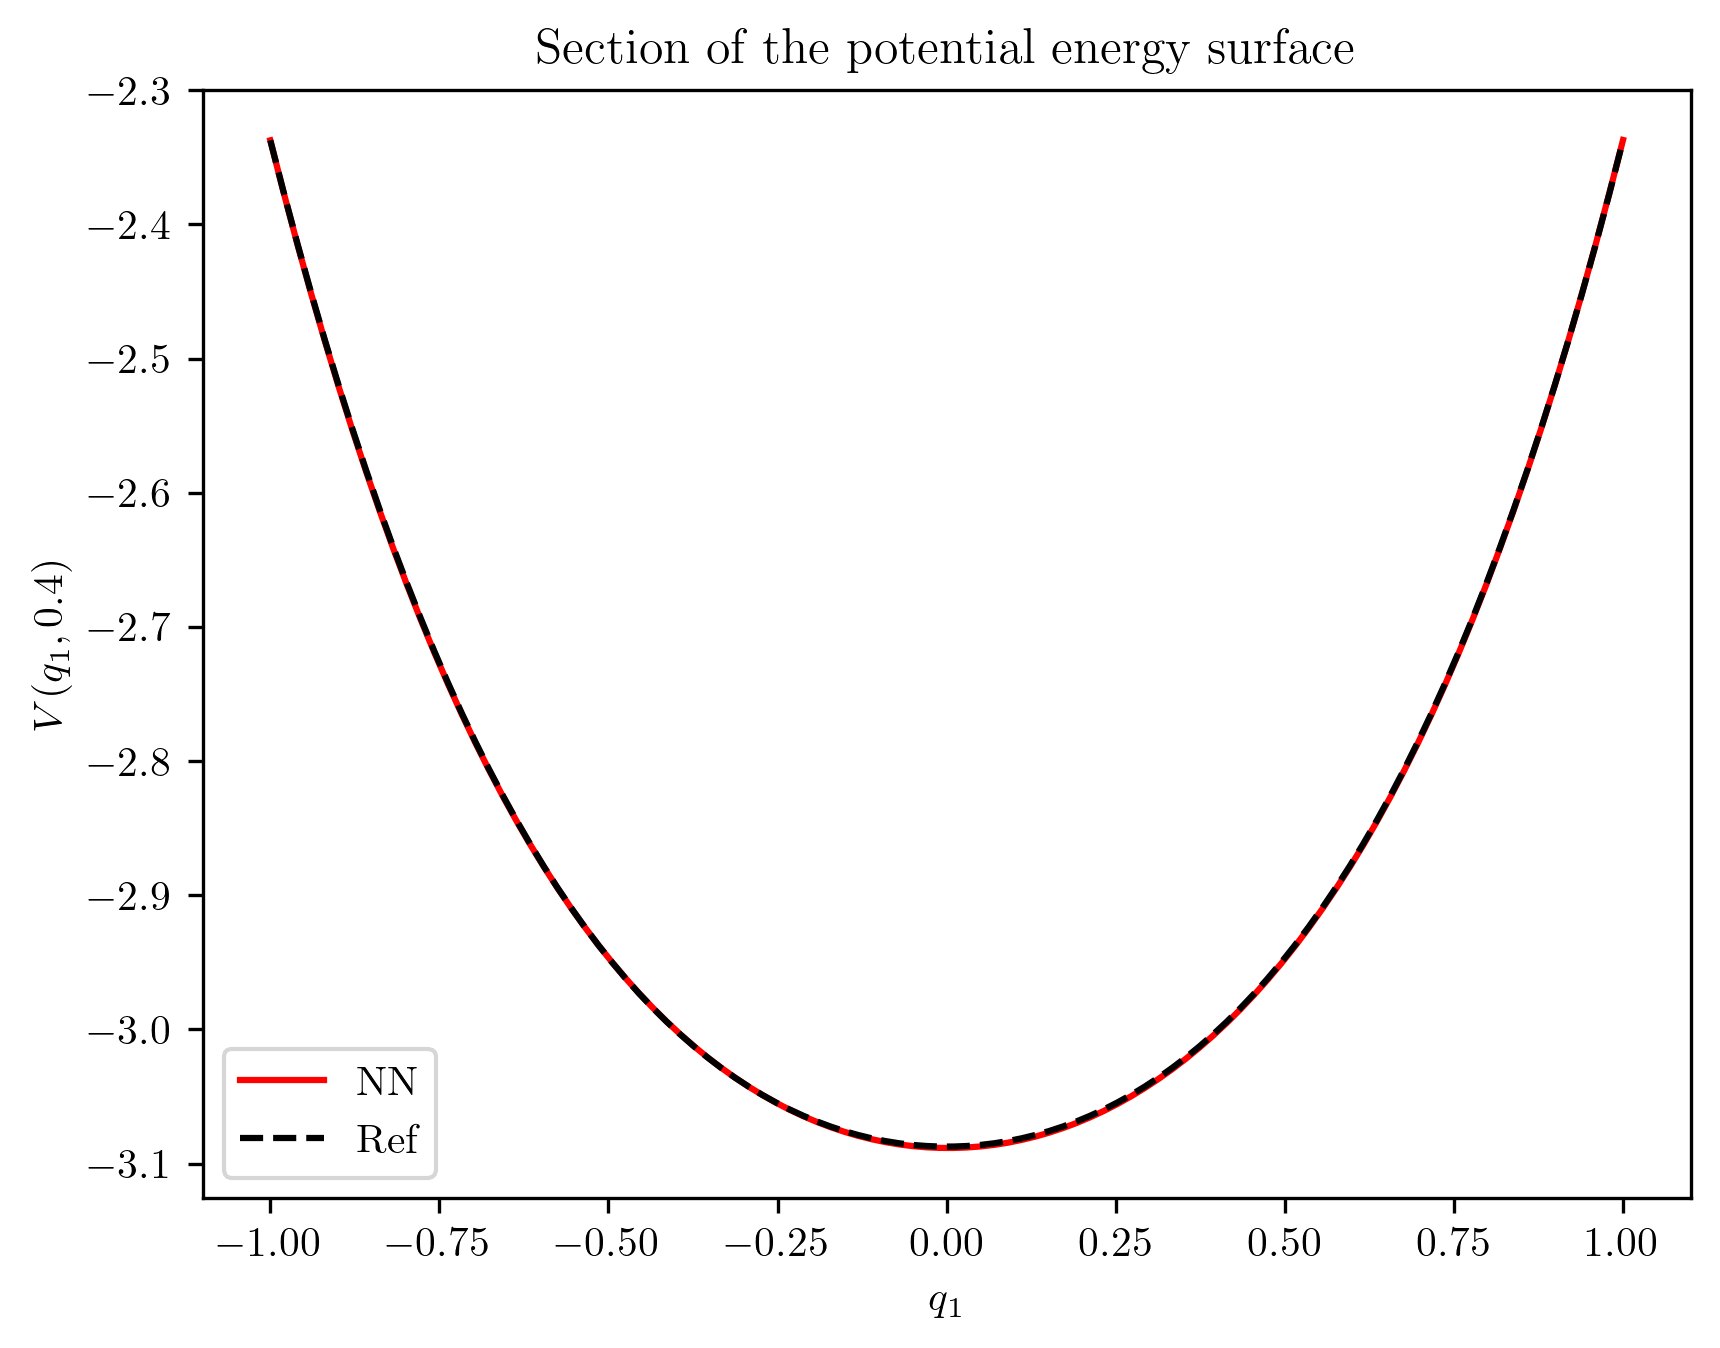

In [211]:
xx = np.linspace(-1,1,100)
val = 0.4
fixed = val * np.ones_like(xx)

input = torch.tensor(np.stack([xx,fixed]).T,dtype=torch.float32).to(device)
pot = lambda q1,q2 : (q1**4 + q2**4)/4 + (q1**2 + q2**2)/2
true = pot(xx,fixed)

net_pot = Ham.seq(input).squeeze().detach().cpu().numpy()
plt.plot(xx,net_pot,'r-',label="NN")
plt.plot(xx,true-true[0]+net_pot[0],'k--',label="Ref")
plt.legend()
plt.title("Section of the potential energy surface")
plt.xlabel(r"$q_1$")
plt.ylabel(rf"$V(q_1,{val})$")
plt.show();